In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Funciones

## Matriz

In [40]:
#Graficacion de los datos y la estimacion de matriz por densidad neutron crossplot
def xplotnd(nphi, rhob, gr, c): #nphi en porcentajes, c hace referencia a la grafica a utilizar 
    if c==1: #Halliburton
        nd = plt.imread('nd1.jpg')
    elif c==2: #Schlumberger
        nd = plt.imread('nd2.jpg')
    extent = [-5 * 3, 45 * 3, 3 * 150, 1.9 * 150]
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot()
    #fig.subplots_adjust(left=0,right=0,bottom=0, top=0)
    plt.scatter(nphi*300, rhob*150, c=gr, s=50, cmap='gist_rainbow')
    cbar = plt.colorbar(ticks=np.linspace(0,100,11))
    cbar.set_label('Rayos Gamma', size=16)
    plt.clim(0,100)
    plt.imshow(nd, extent=extent)
    plt.title("Neutron-Densidad Crossplot", fontsize=20, fontweight='bold')
    ax.set_xlabel("Porosidad Neutron (*3 %)", fontsize=14)
    ax.set_ylabel("Densidad (*150 g/cm3)", fontsize=14)

In [3]:
#Graficacion de los datos y la estimacion de matriz por sonico 
def xplotsd(dt, rhob, gr, c): #c hace referencia a la grafica a utilizar 
    if c==1: #Halliburton
        ns = plt.imread('ns1.jpg')
        ratio=2
    elif c==2: #Schlumberger
        ns = plt.imread('ns2.jpg')
        ratio=1.5
    extent = [40*ratio, 120*ratio, 3 * 150, 1.9 * 150]
    fig = plt.figure(figsize=(20, 15))
    ax= fig.add_subplot()
    plt.scatter(dt*ratio, rhob*150, c=gr, s=50, cmap='gist_rainbow')
    cbar = plt.colorbar(ticks=np.linspace(0,100,11))
    cbar.set_label('Rayos Gamma', size=16)
    plt.clim(0,100)
    plt.imshow(ns, extent=extent)
    plt.title("Sonico Densidad Crossplot", fontsize=20, fontweight='bold')
    ax.set_xlabel("Tiempo de transito (x"+str(ratio)+ r' $\mu$''s/ft)', fontsize=14)
    ax.set_ylabel("Densidad (*150 g/cm3)", fontsize=14)

## Rw

In [4]:
#calculo de Rw por medio de Archie, metodo de Hingle
def Rw(phi, rt, archieM): #porosidad y resistividad del registro
    rw=(phi**archieM)*rt
    return np.round(rw,4)

## Igr

In [5]:
#Indice de rayos gamma
def i_gr(gr, grmax, grmin): #rayos gamma del registro, gr max, gr min
    ish = (gr - grmin) / (grmax - grmin)
    return np.round(ish, 4)

## Vsh

In [6]:
#calculo de vsh por larinov
def vsh_lar(gr, grmax, grmin): #rayos gamma del registro, gr max, gr min
    ig=i_gr(gr, grmax, grmin)
    vsh=0.33*(2**(2*ig)-1)
    return np.round(vsh, 4)

In [7]:
#calculo de vsh por clavier
def vsh_cla(gr, grmax, grmin): #rayos gamma del registro, gr max, gr min
    ig=i_gr(gr, grmax, grmin)
    vsh=1.7-(3.38-(ig+0.7)**2)**0.5
    return np.round(vsh,4)

In [8]:
#calculo de vsh por stieber
def vsh_sti(gr, grmax, grmin): #rayos gamma del registro, gr max, gr min
    ig=i_gr(gr, grmax, grmin)
    vsh=ig/(3-2*ig)
    return np.round(vsh,4)

In [9]:
#calculo de vsh por larinov rocas terciarias
def vsh_lart(gr, grmax, grmin): #rayos gamma del registro, gr max, gr min
    ig=i_gr(gr, grmax, grmin)
    vsh=0.083*(2**(3.7*ig)-1)
    return np.round(vsh,4)

## Porosidad

In [10]:
#calculo de la porosidad densidad
def por_rho(rhob, rhom, rhof): #densidad del registro, densidad matriz, densidad fluido
    denpor = (rhom - rhob) / (rhom - rhof)
    return np.round(denpor, 4)

In [11]:
#calculo de la porosidad sonica
def por_son(dtr, dtm, dtf): #dt del registro, dt matriz, dt fluido Formula de Willey
    sonpor = (dtr - dtm) / (dtf - dtm)
    return np.round(sonpor, 4)

In [12]:
#calculo de la porosidad total
por_tot = lambda nphi,dn: (nphi+dn)/2 #porosidad neutron, porosidad densidad

In [13]:
#calculo de la porosidad efectiva
def por_e(phia, vsh): #porosidad densidad, volumen de arcilla 
    phie=phia*(1-vsh)
    return np.round(phie, 4)

## Vma

In [14]:
def Vma(Vsh, Phie):
    vma=1-(Vsh-Phie)
    return np.round(vma,4)

## Sw

In [15]:
#calculo de sw por archie
def sw_archie(por, rt, rw, archieA, archieM, archieN): #porosidad, resistividad, rw, parametro a, m y n
    sw = ((archieA/por**archieM)*(rw/rt))**(1/archieN)
    return sw

In [16]:
#calculo de sw por simandoux
def sw_simandoux(phie, rt, rw, archieA, archieM, archieN, vshale, rshale): #rshale resistividad de la caliza
    A = archieA * rw / (2*phie ** archieM)
    B = vshale/rshale
    C = (4*phie**archieM)/(archieA*rw*rt)
    sw = A*((B**2+C)**0.5-B)
    return sw

## Mineralogia

In [70]:
#calculo de mineralogia (Ellis & Singer, 2007) M = RV
def complex_mineralogy(rhob, dt, nphi, min): #recibe densidad, tiempo de transito, neutron y el numero de minerales
    
    datos=pd.DataFrame({
        'RHOB':rhob,
        'NPHI':nphi,
        'DTCO':dt
    })
    
    minerales=pd.DataFrame({
        'substancia':['Cuarzo', 'Calcita', 'Dolomita', 'Agua'],
        'rho':[2.65, 2.71, 2.87, 1.00],
        'np':[-0.02, 0, 0.02, 1.00],
        'dt':[180, 156, 143, 620]
    })
    
    #Matriz M
    M=np.empty((0,min-1))
    for a in range(0, datos.shape[0]):
        M = np.append(M, [datos.loc[a,['RHOB', 'NPHI', 'DTCO']].to_numpy()], axis=0)

    M = M.T
    M = np.append(M, [np.ones(datos.shape[0])], axis=0)
    
    #Matriz R
    R = np.empty((0,min))
    for a in range(1, min):
        R = np.append(R, [minerales.iloc[:,a].to_numpy()], axis=0)
    
    R = np.append(R, [np.ones(minerales.shape[1])], axis=0)
    
    #Matriz V
    V = np.empty((0,min))
    for a in range(0,M.shape[1]):
        V = np.append(V,[np.linalg.solve(R,M[:,a].T)], axis=0)

    Solucion=pd.DataFrame(V,columns=['Cuarzo', 'Calcita', 'Dolomita', 'Porosidad'])
    return Solucion


## Permeabilidad

In [18]:
#estimacion de permeabilidad
def ktimur(Phie, Sw): #timur
    k=(0.136*Phie**4.4)/Sw
    return k

## Zona de Paga

In [19]:
#estimacion de la zona de paga
def PayIndex(Phie, archieM, Rt, archieA, Rw):
    PI=((Phie**archieM*Rt)/archieA)*(1/Rw)
    return PI

## Volumetria

In [20]:
#calculo del volumen de agua
def BVW(Sw, Phi):
    bvw=Sw*Phi
    return bvw

In [21]:
#calculo del volumen de hidrocarburo
def BVH(Sw,Phie):
    hv=(1-Sw)*Phie
    return np.round(hv,4)

# Datos

In [22]:
depth=np.array([4103.9795,4104.1319,4104.2843,4104.4367,4104.5891,4104.7415,4104.8939,4105.0463,4105.1987,4105.3511,4105.5035,4105.6559]) #de 4000 m a 4620 cada 
gr=np.array([59.7577,59.3771,59.1994,60.5714,65.1616,67.5946,62.9865,60.6234,62.1552,65.5765,67.2224,63.4949])
rt=np.array([2.8034,2.7868,3.1434,2.9580,3.0364,2.9471,2.9498,2.8564,3.2268,3.2203,3.1097,2.8334])
rhob=np.array([2.0208,2.2247,2.5584,2.6008,2.5799,2.5732,2.5684,2.5778,2.5676,2.5503,2.5454,2.5659])
dtco=np.array([84.5280,78.7209,78.5210,78.7156,75.6605,78.8588,78.2041,79.4514,79.6140,78.9172,77.0866,79.7477])
nphi=np.array([0.2210,0.2146,0.1922,0.1833,0.1877,0.1924,0.1873,0.1871,0.1974,0.2068,0.2075,0.1965])

# Calculos

## (a) Matriz

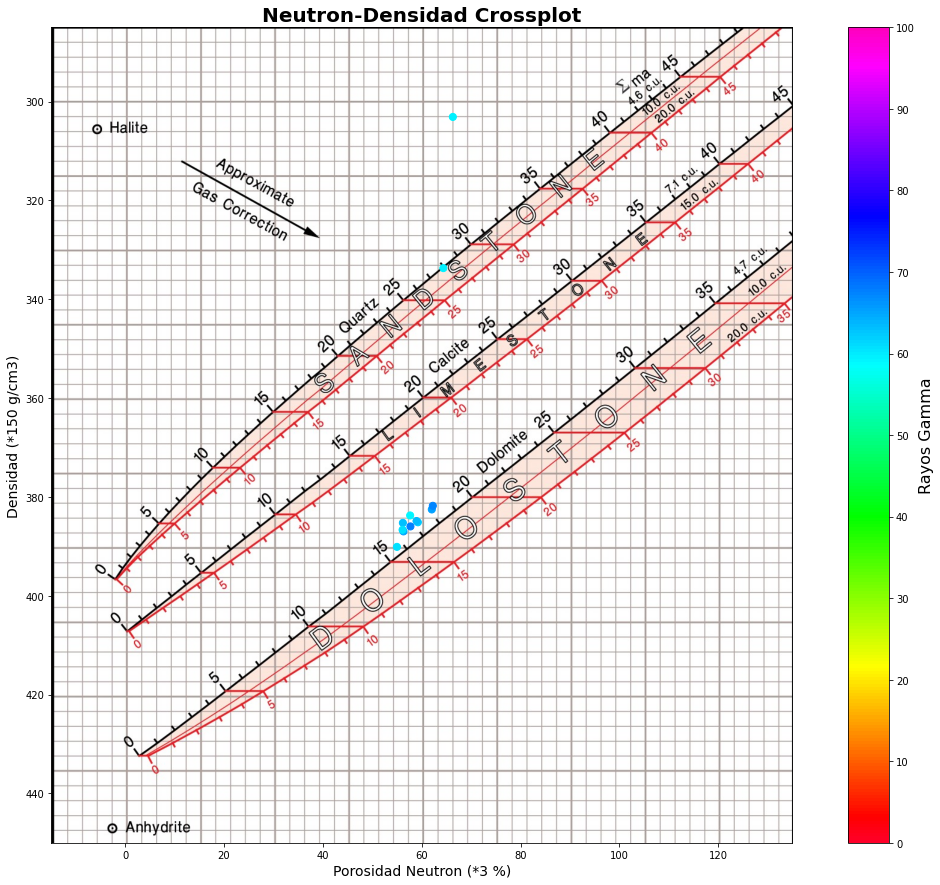

In [41]:
#Matriz
xplotnd(nphi, rhob, gr, 1)

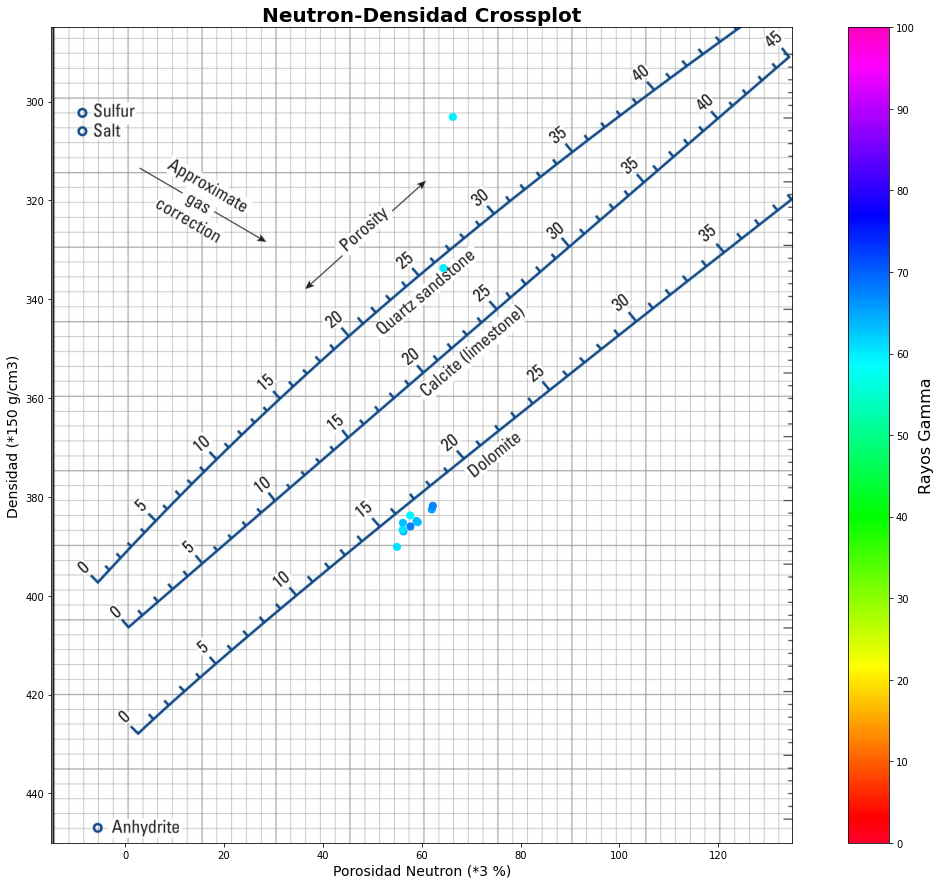

In [24]:
xplotnd(nphi, rhob, gr, 2)

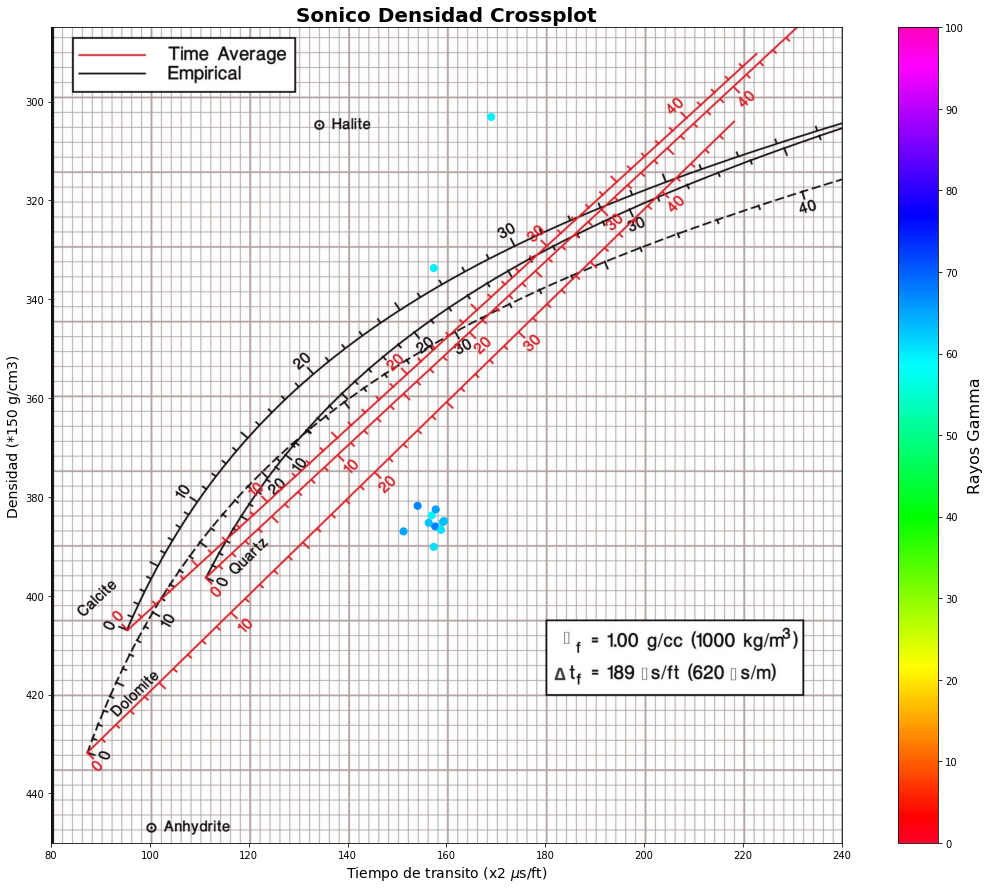

In [25]:
xplotsd(dtco, rhob, gr, 1)

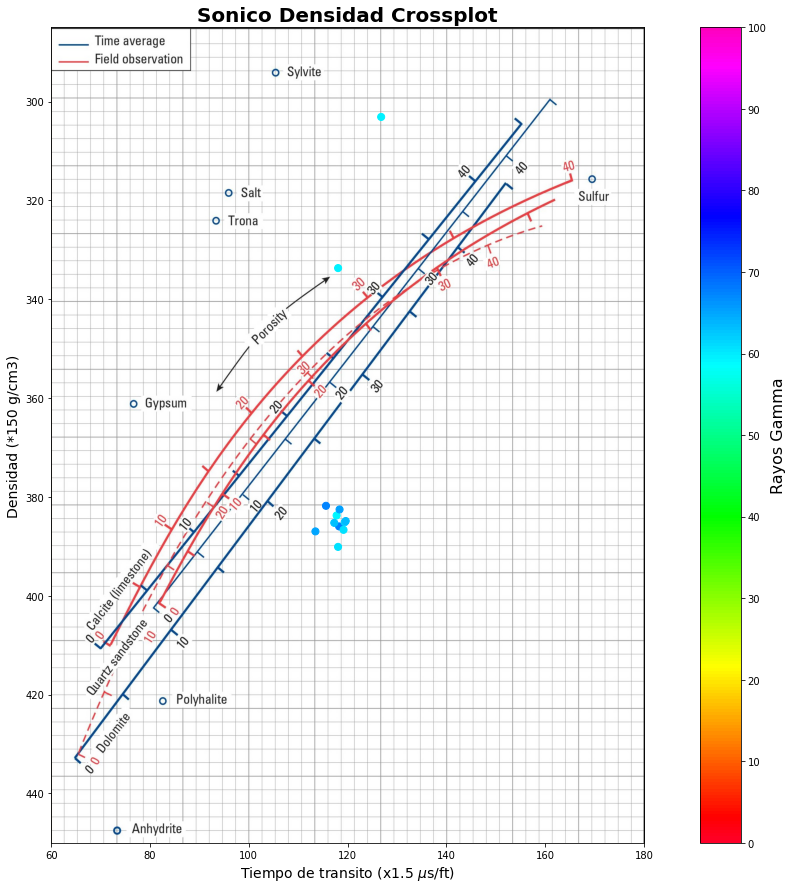

In [26]:
xplotsd(dtco, rhob, gr, 2)

Se determina que es una matriz de dolomita rho=2.86

## (b) Volumen de arcilla

In [27]:
#Calculo de Vsh
vsh1=vsh_lar(gr, 100, 20)
vsh1

array([0.3273, 0.3229, 0.3209, 0.3365, 0.3917, 0.4228, 0.365 , 0.3372,
       0.3551, 0.397 , 0.418 , 0.3712])

In [28]:
vsh2=vsh_cla(gr, 100, 20)
vsh2

array([0.3046, 0.3005, 0.2986, 0.3133, 0.3654, 0.3949, 0.3402, 0.3139,
       0.3308, 0.3704, 0.3904, 0.346 ])

## (c) Estimacion de Rw

In [29]:
#Para Rw por el metodo de archie necesitamos el factor m y phi
phi1=por_rho(rhob,2.87,1)
rw=Rw(nphi,rt,2)
rw

array([0.1369, 0.1283, 0.1161, 0.0994, 0.107 , 0.1091, 0.1035, 0.1   ,
       0.1257, 0.1377, 0.1339, 0.1094])

## (d) Calculo de volumenes

In [30]:
Vsh=vsh1
Vsh

array([0.3273, 0.3229, 0.3209, 0.3365, 0.3917, 0.4228, 0.365 , 0.3372,
       0.3551, 0.397 , 0.418 , 0.3712])

In [31]:
phia=por_rho(rhob,2.86,1)
Phie=por_e(phia,Vsh)
Phie

array([0.3035, 0.2313, 0.1102, 0.0925, 0.0916, 0.089 , 0.0996, 0.1005,
       0.1014, 0.1004, 0.0984, 0.0994])

In [32]:
Vmat=Vma(Vsh,Phie)
Vmat

array([0.9762, 0.9084, 0.7893, 0.756 , 0.6999, 0.6662, 0.7346, 0.7633,
       0.7463, 0.7034, 0.6804, 0.7282])

## (e) Obtener phit, phie, phi1, phi2

In [33]:
Phit=por_tot(nphi,phia)
Phit

array([0.3361 , 0.2781 , 0.1772 , 0.16135, 0.16915, 0.1733 , 0.17205,
       0.1694 , 0.1773 , 0.18665, 0.1883 , 0.1773 ])

In [34]:
Phie

array([0.3035, 0.2313, 0.1102, 0.0925, 0.0916, 0.089 , 0.0996, 0.1005,
       0.1014, 0.1004, 0.0984, 0.0994])

## (f) Estimar Sw

In [35]:
Sw1=sw_archie(Phie,rt,rw,1,2,2)
Sw1

array([0.72811587, 0.92765138, 1.74395266, 1.98176601, 2.04935372,
       2.16184689, 1.88067846, 1.86176313, 1.94645183, 2.05961047,
       2.10880267, 1.97682549])

In [36]:
Sw2=sw_simandoux(Phie,rt,rw,1,2,2,Vsh,80)
Sw2

array([0.72508194, 0.92282425, 1.72488379, 1.95748411, 2.01837197,
       2.12575674, 1.8570281 , 1.84101424, 1.91950841, 2.02599425,
       2.0729839 , 1.95130425])

## (g) Eleccion de Sw

In [37]:
#Elijo Simandoux
Sw=Sw2
Sw

array([0.72508194, 0.92282425, 1.72488379, 1.95748411, 2.01837197,
       2.12575674, 1.8570281 , 1.84101424, 1.91950841, 2.02599425,
       2.0729839 , 1.95130425])

## (h) Estimar mineralogia compleja

In [72]:
mc=complex_mineralogy(rhob,dtco,nphi,4)
mc

,Cuarzo,Calcita,Dolomita,Porosidad
0,-9.332626,16.305565,-6.129884,0.156945
1,-8.473817,14.054008,-4.719709,0.139518
2,-6.512165,9.652352,-2.247085,0.106898
3,-6.180982,9.028847,-1.946475,0.098610
4,-6.476063,9.533202,-2.158487,0.101348
5,-6.423961,9.443842,-2.126329,0.106447
6,-6.416820,9.506496,-2.192489,0.102813
7,-6.310945,9.302664,-2.094490,0.102771
8,-6.478532,9.505559,-2.137609,0.110582
9,-6.709881,9.848298,-2.256142,0.117725


## (i) Calcular permeabilidad

In [73]:
K=ktimur(Phie,Sw)
K

array([9.87756914e-04, 2.34851152e-04, 4.81258133e-06, 1.96274685e-06,
       1.82338252e-06, 1.52525119e-06, 2.86458374e-06, 3.00616236e-06,
       2.99858174e-06, 2.71975032e-06, 2.43288406e-06, 2.70217834e-06])

## (j) Zonas de paga

In [75]:
ZP=PayIndex(Phie,2,rt,1,rw)
ZP

array([1.88624895, 1.16206497, 0.3287991 , 0.2546216 , 0.2381037 ,
       0.21396864, 0.28272935, 0.28850354, 0.26394454, 0.23573812,
       0.22486824, 0.25589591])

## (k) Estimar volumetria del yacimiento

In [76]:
Vol=BVH(Sw,Phie)
Vol

array([ 0.0834,  0.0179, -0.0799, -0.0886, -0.0933, -0.1002, -0.0854,
       -0.0845, -0.0932, -0.103 , -0.1056, -0.0946])

## (l) Exportar desarrollo, resultados y pozo en pdf

In [86]:
print(len(Phie))

12


In [87]:
resultado=pd.DataFrame({
    'Depth':depth,
    'GR':gr,
    'RT':rt,
    'DTCO':dtco,
    'VSH':Vsh,
    'RW':rw,
    'VMA':Vmat,
    'PHIE':Phie,
    'PHIT':Phit,
    'SW':Sw,
    'K':K,
    'PI':ZP,
    'BVH':Vol,
})
resultado

,Depth,GR,RT,DTCO,VSH,RW,VMA,PHIE,PHIT,SW,K,PI,BVH
0,4103.9795,59.7577,2.8034,84.5280,0.3273,0.1369,0.9762,0.3035,0.33610,0.725082,0.000988,1.886249,0.0834
1,4104.1319,59.3771,2.7868,78.7209,0.3229,0.1283,0.9084,0.2313,0.27810,0.922824,0.000235,1.162065,0.0179
2,4104.2843,59.1994,3.1434,78.5210,0.3209,0.1161,0.7893,0.1102,0.17720,1.724884,0.000005,0.328799,-0.0799
3,4104.4367,60.5714,2.9580,78.7156,0.3365,0.0994,0.7560,0.0925,0.16135,1.957484,0.000002,0.254622,-0.0886
4,4104.5891,65.1616,3.0364,75.6605,0.3917,0.1070,0.6999,0.0916,0.16915,2.018372,0.000002,0.238104,-0.0933
5,4104.7415,67.5946,2.9471,78.8588,0.4228,0.1091,0.6662,0.0890,0.17330,2.125757,0.000002,0.213969,-0.1002
6,4104.8939,62.9865,2.9498,78.2041,0.3650,0.1035,0.7346,0.0996,0.17205,1.857028,0.000003,0.282729,-0.0854
7,4105.0463,60.6234,2.8564,79.4514,0.3372,0.1000,0.7633,0.1005,0.16940,1.841014,0.000003,0.288504,-0.0845
8,4105.1987,62.1552,3.2268,79.6140,0.3551,0.1257,0.7463,0.1014,0.17730,1.919508,0.000003,0.263945,-0.0932
9,4105.3511,65.5765,3.2203,78.9172,0.3970,0.1377,0.7034,0.1004,0.18665,2.025994,0.000003,0.235738,-0.1030
